In [619]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

from keras.models import load_model

# <a id='data_analysis'>1. Data analysis</a>

train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

#### Dataset statistics  for each parameter

df.describe()

# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

for i in range(26):
    print(str(i))
    print(df['Section-'+str(i)])

#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

df.head()



def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

def create_dataset(X, look_back=5):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128
0
0          1
1          1
2          1
3          1
4          1
        ... 
20626    100
20627    100
20628    100
20629    100
20630    100
Name: Section-0, Length: 20631, dtype: int64
1
0          1
1          2
2          3
3          4
4          5
        ... 
20626    196
20627    197
20628    198
20629    199
20630    200
Name: Section-1, Length: 20631, dtype: int64
2
0       -0.0007
1        0.0019
2       -0.0043
3        0.0007
4       -0.0019
          ...  
20626   -0.0004
20627   -0.0016
20628    0.0004
20629   -0.0011
20630   -0.0032
Name: Section-2, Length: 20631, dtype: float64
3
0       -0.0004
1       -0.0003
2        0.0003
3        0.0000
4       -0.0002
          ...  
20626   -0.0003
20627   -0.0005
20628    0.0000
20629    0.0003
20630   -0.0005
Name: Section-3, Length: 20631, dtype: float64
4
0        100.0
1        100.0
2        100.0
3        100.0
4        100.0
         ...  
20626    100.0
20627   

In [620]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

df_test_rul = pd.read_csv(RUL_file, names=['rul'])
df_test_rul.head()
print(df_test.describe())
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

print(max_cycles)

df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

test_data = []
i = 0
count = 0
while i < len(df_test):
    temp = []
    j = int(max_cycles[count])
    count = count+1
    #print(j)
    if j == 0:
        break
    while j!=0:
        temp.append(df_test[i])
        i=i+1
        j=j-1
    test_data.append(temp)

print(len(test_data))

y_new = []
for i in range(len(test_data)):
    y_new.append(pd.DataFrame(test_data[i]))

y_new[0]

          Section-0     Section-1     Section-2     Section-3  Section-4  \
count  13096.000000  13096.000000  13096.000000  13096.000000    13096.0   
mean      51.543907     76.836515     -0.000011      0.000004      100.0   
std       28.289423     53.057749      0.002203      0.000294        0.0   
min        1.000000      1.000000     -0.008200     -0.000600      100.0   
25%       28.000000     33.000000     -0.001500     -0.000200      100.0   
50%       52.000000     69.000000      0.000000      0.000000      100.0   
75%       76.000000    113.000000      0.001500      0.000300      100.0   
max      100.000000    303.000000      0.007800      0.000700      100.0   

          Section-5     Section-6     Section-7     Section-8     Section-9  \
count  1.309600e+04  13096.000000  13096.000000  13096.000000  1.309600e+04   
mean   5.186700e+02    642.475088   1588.099204   1404.735362  1.462000e+01   
std    6.014263e-11      0.400899      5.003274      6.688309  2.671743e-12   

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-1.793850,1.049365,1.004600,1.333227,-0.543820,-0.981745,0.157202,-0.501657,-0.734950,-1.135844,-0.112400,-0.698911,-1.521652,-0.692054,-0.435852,-0.266363,0.420595
1,-1.759832,-1.220564,-1.035151,-2.026229,0.095924,-1.467193,1.720949,-1.077473,-0.259251,0.487480,0.721475,-0.143646,0.182103,-1.649791,0.378493,0.899581,0.647087
2,-1.726093,0.140862,0.344897,-0.000094,-0.207106,-0.467327,0.483115,-0.317637,0.000826,0.487480,0.351776,-0.698911,-0.907151,0.657711,0.378493,1.361062,0.966019
3,-1.692628,1.913041,0.007977,-0.050265,-0.786268,0.307571,0.420181,-0.689532,-1.352331,-0.667106,-0.703805,-0.325176,-0.561267,-1.201106,-1.300958,0.748684,0.423078
4,-1.659435,0.640456,0.007977,0.124510,-0.156604,-0.375254,0.562352,-1.077473,-1.453359,-0.498585,0.701649,-0.698911,-0.979154,-0.769737,-2.225587,0.673786,0.919656
5,-1.626511,0.549605,1.004600,-0.906811,-1.859665,-1.519217,0.658272,-1.277873,-0.642431,-0.781596,0.256927,0.209360,-1.255327,-0.026486,-0.435852,0.087849,0.092044
6,-1.593852,0.004646,0.677007,-0.906811,-0.949660,0.073950,0.141959,-0.317637,-0.592885,-0.498585,0.428384,-0.143646,-0.319874,-1.212685,-1.300958,-0.336094,0.692577
7,-1.561456,0.277094,0.007977,0.198716,-1.472454,-0.539442,-0.303737,-0.317637,-0.427703,-1.075645,0.583555,-0.143646,-1.467657,-0.113688,0.378493,1.128675,-0.198844
8,-1.529320,-1.628654,0.007977,-1.538663,1.036596,1.122015,1.101241,-0.137329,-0.930909,-0.172590,0.466932,-0.325176,-0.414103,0.366183,-1.300958,1.517812,1.431071
9,-1.497440,-1.129855,-0.334082,-1.014528,-0.552058,-0.909254,0.755105,-0.501657,-0.529201,-1.507287,0.409171,-0.143646,-0.422230,-0.541921,-1.300958,-0.196261,0.526497


In [621]:
for y in y_new:
    print(len(y))

31
49
126
106
98
105
160
166
55
192
83
217
195
46
76
113
165
133
135
184
148
39
130
186
48
76
140
158
171
143
196
145
50
203
198
126
121
125
37
133
123
156
172
54
152
146
73
78
303
74
144
189
164
121
113
136
160
176
94
147
159
232
155
168
71
147
71
187
54
152
68
131
112
137
88
205
162
72
101
133
213
162
73
172
34
110
56
68
177
146
234
150
244
133
89
97
134
121
97
198


# Lookback = 1

In [622]:
predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i][0:len(y_new[i])-1])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=1)
    predictions.append(test_pred)

In [623]:
predictions = np.array(predictions)

predictions.shape

(100, 1, 17)

In [624]:
actual = []
for i in range(len(y_new)):
    actual.append(y_new[i].iloc[-1])

In [625]:
actual=np.array(actual)

In [626]:
actual = actual.reshape((100,17))
predictions = predictions.reshape((100,17))

In [627]:
print(actual.shape,predictions.shape)

(100, 17) (100, 17)


In [628]:
compare=2
df_actual,df_pred = pd.DataFrame(),pd.DataFrame()

In [629]:
difference = []
for i in range(compare):
    df_actual[i+1],df_pred[i+1] = actual[i],predictions[i]
    difference.append(abs(actual[i]-predictions[i]))
# df_actual,df_pred = df_actual.T,df_pred.T

In [630]:
difference

[array([1.46685899e-04, 2.75651713e+00, 7.75619651e-01, 1.25803515e+00,
        2.06922657e+00, 2.03558910e+00, 1.76586965e+00, 5.17996412e-01,
        2.63365706e+00, 1.60228600e+00, 6.39447080e-01, 3.16986864e-01,
        1.36724908e-01, 1.28838169e+00, 9.76802837e-01, 2.27985565e+00,
        1.25516531e+00]),
 array([9.95646376e-05, 1.89115423e+00, 2.78437558e-01, 1.19603257e+00,
        4.37387922e-01, 1.28873178e+00, 8.69665732e-02, 7.05175858e-02,
        1.38227672e-01, 6.89345746e-01, 4.70611379e-01, 8.15310799e-01,
        2.46203423e-01, 6.39100979e-01, 1.77655070e+00, 5.36537090e-01,
        1.72560963e-01])]

In [631]:
df_diff =  pd.DataFrame(difference)
df_diff = df_diff.T

In [632]:
columns=[]
for i in range(compare):
    columns.append('Engine '+str(i+1))
df_pred.columns=columns
df_actual.columns=columns
df_diff.columns=columns

In [633]:
df_pred['Features']=np.arange(1,18)

In [634]:
df_actual['Features']=np.arange(1,18)

In [635]:
df_diff['Features']=np.arange(1,18)

In [636]:
df_diff

,Engine 1,Engine 2,Features
0,0.000147,0.000100,1
1,2.756517,1.891154,2
2,0.775620,0.278438,3
3,1.258035,1.196033,4
4,2.069227,0.437388,5
5,2.035589,1.288732,6
6,1.765870,0.086967,7
7,0.517996,0.070518,8
8,2.633657,0.138228,9
9,1.602286,0.689346,10


In [637]:
display(df_pred,df_actual)

,Engine 1,Engine 2,Features
0,-0.882698,-0.427647,1
1,-3.024257,-1.068978,2
2,0.552318,-0.612520,3
3,-0.961016,1.419393,4
4,0.668062,0.159354,5
5,1.171548,-0.361064,6
6,-0.781259,-0.317551,7
7,-0.305302,0.478908,8
8,-2.688716,-1.561335,9
9,-2.558941,0.578149,10


,Engine 1,Engine 2,Features
0,-0.882551,-0.427547,1
1,-0.267740,0.822177,2
2,1.327938,-0.334082,3
3,0.297019,0.223360,4
4,-1.401165,-0.278034,5
5,-0.864041,0.927668,6
6,0.984611,-0.404517,7
7,0.212695,0.549425,8
8,-0.055059,-1.423107,9
9,-0.956655,1.267495,10


In [638]:
df_diff.describe()

,Engine 1,Engine 2,Features
count,17.000000,17.000000,17.000000
mean,1.312253,0.631399,9.000000
std,0.856563,0.586048,5.049752
min,0.000147,0.000100,1.000000
25%,0.639447,0.172561,5.000000
50%,1.258035,0.470611,9.000000
75%,2.035589,0.815311,13.000000
max,2.756517,1.891154,17.000000


In [639]:
df_pred=df_pred.drop(['Features'], axis=1)
df_actual=df_actual.drop(['Features'], axis=1)
df_diff=df_diff.drop(['Features'], axis=1)

In [640]:
display(df_pred,df_actual)

,Engine 1,Engine 2
0,-0.882698,-0.427647
1,-3.024257,-1.068978
2,0.552318,-0.612520
3,-0.961016,1.419393
4,0.668062,0.159354
5,1.171548,-0.361064
6,-0.781259,-0.317551
7,-0.305302,0.478908
8,-2.688716,-1.561335
9,-2.558941,0.578149


,Engine 1,Engine 2
0,-0.882551,-0.427547
1,-0.267740,0.822177
2,1.327938,-0.334082
3,0.297019,0.223360
4,-1.401165,-0.278034
5,-0.864041,0.927668
6,0.984611,-0.404517
7,0.212695,0.549425
8,-0.055059,-1.423107
9,-0.956655,1.267495


Text(0, 0.5, 'Predicted')

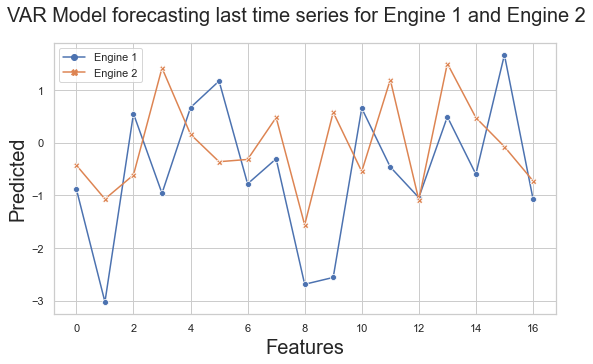

In [641]:
sns.set_theme(style="whitegrid")
a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df_pred,markers=True, dashes=False)
fig.suptitle('VAR Model forecasting last time series for Engine 1 and Engine 2', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Predicted", fontsize=20)


Text(0, 0.5, 'Actual')

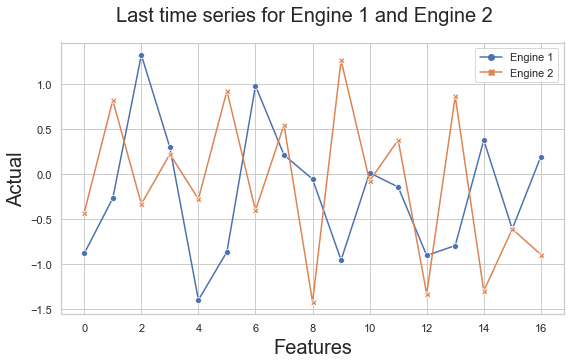

In [642]:
sns.set_theme(style="whitegrid")
a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df_actual,markers=True, dashes=False)
fig.suptitle('Last time series for Engine 1 and Engine 2', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Actual", fontsize=20)

Text(0, 0.5, 'Deviation')

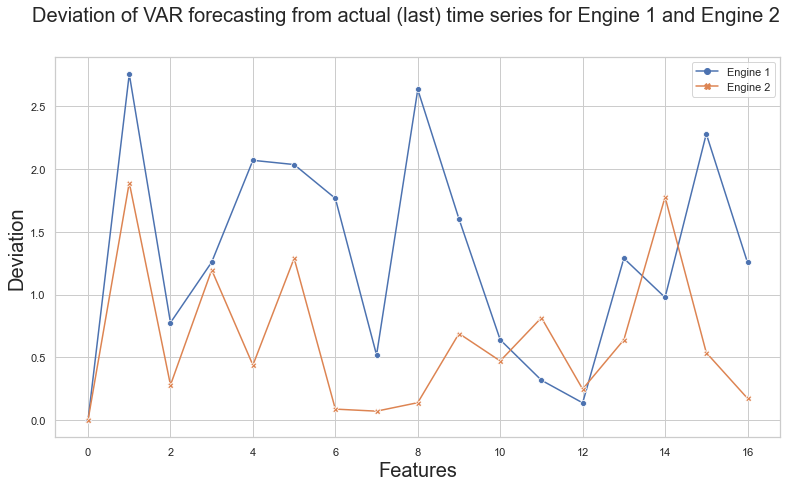

In [643]:
sns.set_theme(style="whitegrid")
a4_dims = (13,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df_diff,markers=True, dashes=False)
fig.suptitle('Deviation of VAR forecasting from actual (last) time series for Engine 1 and Engine 2', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Deviation", fontsize=20)

# 2. For lookback = 5

In [644]:
predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i][0:len(y_new[i])-5])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=5)
    predictions.append(test_pred)

In [645]:
predictions=np.array(predictions)

In [646]:
predictions.shape

(100, 5, 17)

In [647]:
actual = []
for i in range(len(y_new)):
    actual.append(y_new[i].iloc[len(y_new[i])-5:])

In [648]:
actual = np.array(actual)

In [649]:
actual.shape

(100, 5, 17)

In [650]:
diff = []
for i in range(100):
    a = []
    for j in range(5):
        b = []
        for k in range(17):
            b.append(abs(predictions[i][j][k]-actual[i][j][k]))
        a.append(b)
    diff.append(a)
diff = np.array(diff)
diff.shape

(100, 5, 17)

In [651]:
df1_actual=pd.DataFrame(actual[0])
df1_pred=pd.DataFrame(predictions[0])
df1_diff=pd.DataFrame(diff[0])
df1_actual,df1_pred,df1_diff = df1_actual.T,df1_pred.T,df1_diff.T

In [652]:
columns=['1st Step','2nd Step','3rd Step','4th Step','5th Step']

In [653]:
df1_actual.columns = columns
df1_pred.columns = columns
df1_diff.columns = columns

In [654]:
df1_diff

,1st Step,2nd Step,3rd Step,4th Step,5th Step
0,0.000008,0.000033,0.000073,0.000112,0.000149
1,4.813807,1.966853,0.269477,5.167650,2.487968
2,0.606522,0.051680,1.939946,4.968430,0.102343
3,3.384817,0.216599,1.110632,0.523434,1.043624
4,0.659054,0.173680,0.930959,0.606835,1.726322
5,2.003810,0.980261,0.494288,1.178982,0.409027
6,1.594870,0.643524,0.126278,0.824086,2.552013
7,1.252054,0.304961,0.536386,0.898382,0.590533
8,1.256944,2.034881,0.808656,1.971636,1.195039
9,1.139624,2.045827,0.874107,0.199100,0.519439


In [655]:
display(df1_actual,df1_pred)

,1st Step,2nd Step,3rd Step,4th Step,5th Step
0,-0.992150,-0.964439,-0.936937,-0.909642,-0.882551
1,-0.313131,1.003924,0.640456,-1.129855,-0.267740
2,0.344897,1.647259,0.344897,1.327938,1.327938
3,-0.987516,-1.398677,-1.343102,0.801560,0.297019
4,-0.265856,1.217975,-0.164675,-0.455494,-1.401165
5,-0.633282,-0.475311,-0.998690,-0.526578,-0.864041
6,0.869233,-0.347077,0.546454,0.467344,0.984611
7,0.382663,0.039405,0.212695,0.382663,0.212695
8,-1.244086,-0.140410,-1.242765,-1.068938,-0.055059
9,-0.333792,-2.099917,0.088446,-0.014851,-0.956655


,1st Step,2nd Step,3rd Step,4th Step,5th Step
0,-0.992158,-0.964472,-0.937010,-0.909754,-0.882700
1,4.500676,-0.962929,0.909933,4.037795,2.220228
2,-0.261625,1.698939,-1.595049,-3.640492,1.225595
3,2.397302,-1.615277,-0.232470,1.324994,1.340643
4,-0.924910,1.391655,-1.095634,-1.062329,0.325157
5,-2.637092,0.504950,-0.504402,-1.705560,-0.455014
6,-0.725637,-0.990601,0.672733,1.291430,-1.567402
7,-0.869392,-0.265556,0.749081,-0.515720,-0.377838
8,0.012857,-2.175291,-2.051421,0.902698,-1.250098
9,-1.473416,-0.054091,-0.785661,-0.213951,-0.437216


In [656]:
df_diff.describe()

,Engine 1,Engine 2
count,17.000000,17.000000
mean,1.312253,0.631399
std,0.856563,0.586048
min,0.000147,0.000100
25%,0.639447,0.172561
50%,1.258035,0.470611
75%,2.035589,0.815311
max,2.756517,1.891154


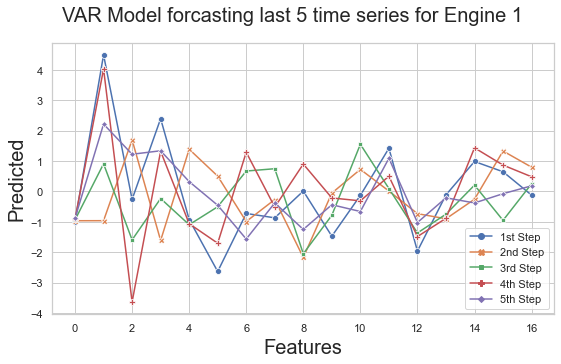

In [657]:
sns.set_theme(style="whitegrid")

a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_pred,markers=True, dashes=False)
fig.suptitle('VAR Model forcasting last 5 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Predicted", fontsize=20)
plt.legend(loc='lower right')

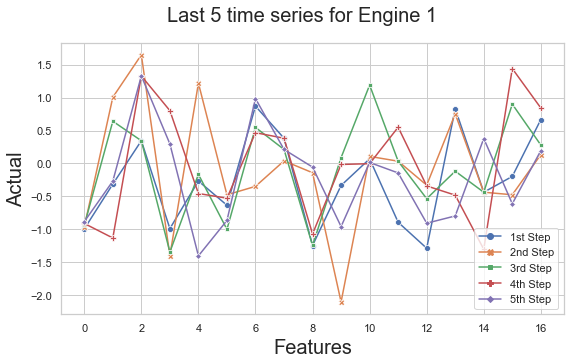

In [658]:
sns.set_theme(style="whitegrid")

a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_actual,markers=True, dashes=False)
fig.suptitle('Last 5 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.legend(loc='lower right')

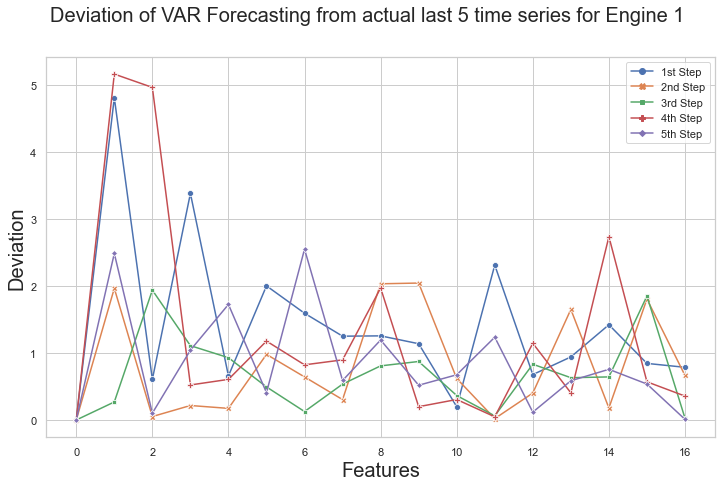

In [659]:
sns.set_theme(style="whitegrid")

a4_dims = (12,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_diff,markers=True, dashes=False)
fig.suptitle('Deviation of VAR Forecasting from actual last 5 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Deviation", fontsize=20)
plt.legend(loc='upper right')

# Lookback = 10

In [660]:
predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i][0:len(y_new[i])-10])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=10)
    predictions.append(test_pred)

predictions=np.array(predictions)

print(predictions.shape)

actual = []
for i in range(len(y_new)):
    actual.append(y_new[i].iloc[len(y_new[i])-10:])

actual = np.array(actual)

print(actual.shape)

# predictions = predictions.reshape((100,17,10))
# actual = actual.reshape((100,17,10))

diff = []
for i in range(100):
    a = []
    for j in range(10):
        b = []
        for k in range(17):
            b.append(abs(predictions[i][j][k]-actual[i][j][k]))
        a.append(b)
    diff.append(a)
diff = np.array(diff)
diff.shape

df1_actual=pd.DataFrame(actual[0])
df1_pred=pd.DataFrame(predictions[0])
df1_diff=pd.DataFrame(diff[0])
df1_actual,df1_pred,df1_diff = df1_actual.T,df1_pred.T,df1_diff.T

columns=['1st Step','2nd Step','3rd Step','4th Step','5th Step','6th Step','7th Step','8th Step','9th Step','10th Step']

df1_actual.columns = columns
df1_pred.columns = columns
df1_diff.columns = columns





(100, 10, 17)
(100, 10, 17)


In [661]:
display(df1_actual,df1_pred,df1_diff)



,1st Step,2nd Step,3rd Step,4th Step,5th Step,6th Step,7th Step,8th Step,9th Step,10th Step
0,-1.133911,-1.105123,-1.076555,-1.048205,-1.020071,-0.992150,-0.964439,-0.936937,-0.909642,-0.882551
1,0.549605,0.413342,-0.267740,1.276593,2.140416,-0.313131,1.003924,0.640456,-1.129855,-0.267740
2,0.344897,0.007977,-0.334082,-1.035151,-1.761948,0.344897,1.647259,0.344897,1.327938,1.327938
3,-0.025155,-0.880020,-0.355344,-0.536613,0.049888,-0.987516,-1.398677,-1.343102,0.801560,0.297019
4,-1.067858,-0.092155,1.225497,-1.142116,-0.962288,-0.265856,1.217975,-0.164675,-0.455494,-1.401165
5,-0.043770,-1.526417,-0.659348,-0.646305,0.544911,-0.633282,-0.475311,-0.998690,-0.526578,-0.864041
6,-0.532316,2.116188,-0.754600,-0.053928,1.270033,0.869233,-0.347077,0.546454,0.467344,0.984611
7,-1.277873,-0.501657,0.039405,0.713093,0.212695,0.382663,0.039405,0.212695,0.382663,0.212695
8,-1.198054,-0.516802,-1.625947,-1.557891,-0.365354,-1.244086,-0.140410,-1.242765,-1.068938,-0.055059
9,-0.781596,-1.196520,-0.610509,-0.172590,-0.388317,-0.333792,-2.099917,0.088446,-0.014851,-0.956655


,1st Step,2nd Step,3rd Step,4th Step,5th Step,6th Step,7th Step,8th Step,9th Step,10th Step
0,-1.133933,-1.105173,-1.076654,-1.048382,-1.020344,-0.992543,-0.964976,-0.937638,-0.910508,-0.883584
1,-1.420061,-3.259418,-1.812823,-6.957256,-6.859219,-5.042775,-5.429682,-4.981650,-0.054678,1.038066
2,1.261134,-0.665899,-1.604739,-1.520241,-3.381790,-2.039301,-0.194052,-1.530311,-1.498139,0.625536
3,-0.901179,-1.179953,-1.104849,-2.391043,-2.714764,-2.616363,-1.750303,-2.540572,-0.491926,0.121915
4,0.285676,1.027662,1.780580,3.770217,0.608066,1.845770,1.402901,-0.261444,-0.591310,-2.562591
5,-1.391613,-0.493357,-0.886060,-0.143634,-1.150904,0.107318,0.859025,1.282220,1.277454,0.637088
6,1.125080,1.921448,3.113993,2.511397,4.054567,4.217800,1.053622,2.139189,1.393985,-1.309307
7,0.129761,1.315711,-0.078737,0.274353,0.979479,0.713667,0.618822,0.178912,-0.643880,-1.472787
8,-0.010252,-0.255749,1.121566,0.154606,0.056154,0.652848,-0.688600,-2.303715,-2.357641,-2.473876
9,-0.987971,-0.124189,-0.649410,-0.872215,-1.653853,-0.136838,-1.639797,-1.713917,-0.415385,-1.754582


,1st Step,2nd Step,3rd Step,4th Step,5th Step,6th Step,7th Step,8th Step,9th Step,10th Step
0,0.000022,0.000050,0.000099,0.000177,0.000273,0.000393,0.000537,0.000700,0.000866,0.001033
1,1.969666,3.672760,1.545083,8.233849,8.999634,4.729644,6.433606,5.622106,1.075178,1.305805
2,0.916238,0.673875,1.270656,0.485090,1.619842,2.384197,1.841311,1.875208,2.826077,0.702402
3,0.876024,0.299933,0.749505,1.854429,2.764652,1.628848,0.351626,1.197470,1.293486,0.175104
4,1.353534,1.119817,0.555083,4.912333,1.570355,2.111626,0.184925,0.096769,0.135816,1.161426
5,1.347843,1.033060,0.226712,0.502671,1.695815,0.740600,1.334336,2.280910,1.804032,1.501129
6,1.657395,0.194740,3.868593,2.565325,2.784534,3.348567,1.400699,1.592735,0.926641,2.293918
7,1.407634,1.817368,0.118143,0.438740,0.766784,0.331005,0.579417,0.033783,1.026543,1.685482
8,1.187803,0.261053,2.747513,1.712497,0.421509,1.896934,0.548190,1.060950,1.288703,2.418818
9,0.206375,1.072331,0.038900,0.699625,1.265536,0.196954,0.460120,1.802363,0.400534,0.797928


In [662]:
df_diff.describe()

,Engine 1,Engine 2
count,17.000000,17.000000
mean,1.312253,0.631399
std,0.856563,0.586048
min,0.000147,0.000100
25%,0.639447,0.172561
50%,1.258035,0.470611
75%,2.035589,0.815311
max,2.756517,1.891154


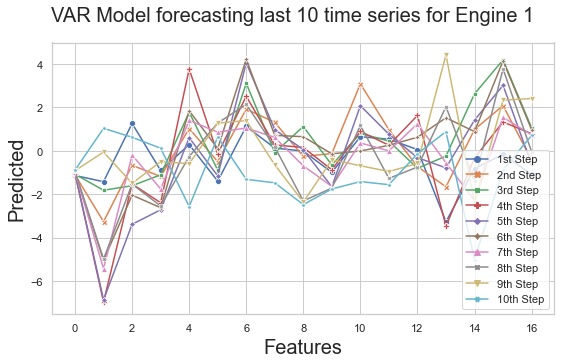

In [663]:
sns.set_theme(style="whitegrid")
a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_pred,markers=True, dashes=False)
fig.suptitle('VAR Model forecasting last 10 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Predicted", fontsize=20)
plt.legend(loc='lower right')

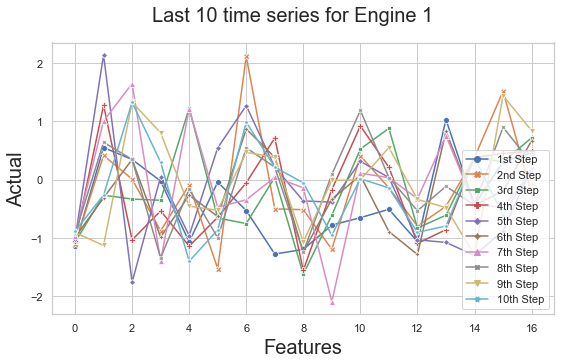

In [664]:
sns.set_theme(style="whitegrid")
a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_actual,markers=True, dashes=False)
fig.suptitle('Last 10 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.legend(loc='lower right')

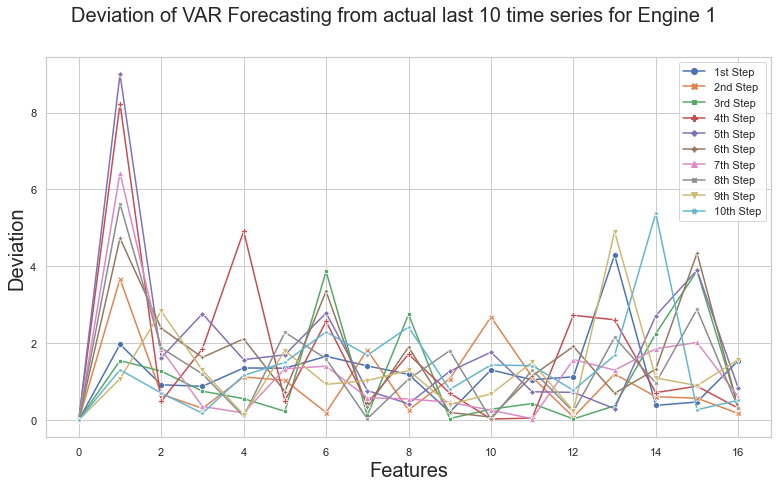

In [665]:
sns.set_theme(style="whitegrid")
a4_dims = (13,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_diff,markers=True, dashes=False)
fig.suptitle('Deviation of VAR Forecasting from actual last 10 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Deviation", fontsize=20)
plt.legend(loc='upper right')

# 4. Lookback=20

(100, 20, 17)
(100, 20, 17)


,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,Step 10,Step 11,Step 12,Step 13,Step 14,Step 15,Step 16,Step 17,Step 18,Step 19,Step 20
0,-1.434440,-1.403314,-1.372433,-1.341795,-1.311398,-1.281238,-1.251313,-1.221620,-1.192157,-1.162922,-1.133911,-1.105123,-1.076555,-1.048205,-1.020071,-0.992150,-0.964439,-0.936937,-0.909642,-0.882551
1,1.185697,-2.534910,0.776744,-0.131555,-0.812313,0.640456,1.594779,1.322043,0.504183,1.731168,0.549605,0.413342,-0.267740,1.276593,2.140416,-0.313131,1.003924,0.640456,-1.129855,-0.267740
2,1.004600,1.004600,-1.395065,-1.035151,1.004600,0.677007,0.344897,0.344897,-0.334082,-0.681651,0.344897,0.007977,-0.334082,-1.035151,-1.761948,0.344897,1.647259,0.344897,1.327938,1.327938
3,0.198716,-1.370860,-0.588865,0.099683,-0.355344,-0.693995,0.321481,-0.075421,0.370273,0.587653,-0.025155,-0.880020,-0.355344,-0.536613,0.049888,-0.987516,-1.398677,-1.343102,0.801560,0.297019
4,-0.108247,0.222937,-0.987570,-0.642908,-0.705104,-1.084805,-0.290219,-0.484206,-0.037944,-0.958078,-1.067858,-0.092155,1.225497,-1.142116,-0.962288,-0.265856,1.217975,-0.164675,-0.455494,-1.401165
5,-1.048015,-0.062025,-0.224976,-0.884107,0.500821,-0.034657,-0.100180,-0.315456,-0.570072,-0.815738,-0.043770,-1.526417,-0.659348,-0.646305,0.544911,-0.633282,-0.475311,-0.998690,-0.526578,-0.864041
6,0.869233,0.373244,1.389717,0.546454,0.035957,0.984611,-0.433090,0.111548,0.803864,0.984611,-0.532316,2.116188,-0.754600,-0.053928,1.270033,0.869233,-0.347077,0.546454,0.467344,0.984611
7,-0.881417,-0.881417,-0.689532,-1.277873,0.549425,-0.137329,-0.501657,-1.077473,-0.317637,-0.317637,-1.277873,-0.501657,0.039405,0.713093,0.212695,0.382663,0.039405,0.212695,0.382663,0.212695
8,-0.752738,-1.301249,-1.350980,-0.457564,-1.826785,-1.277238,-0.984376,-1.139515,-1.949879,-0.332911,-1.198054,-0.516802,-1.625947,-1.557891,-0.365354,-1.244086,-0.140410,-1.242765,-1.068938,-0.055059
9,-0.724133,-0.279665,-0.897851,-0.279665,-0.067054,-0.724133,0.190295,-0.839500,0.290728,-0.225933,-0.781596,-1.196520,-0.610509,-0.172590,-0.388317,-0.333792,-2.099917,0.088446,-0.014851,-0.956655


,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,Step 10,Step 11,Step 12,Step 13,Step 14,Step 15,Step 16,Step 17,Step 18,Step 19,Step 20
0,-1.665398,-1.761785,-1.732022,-1.742667,-1.738139,-1.638249,-1.573177,-1.727328,-1.919508,-2.043101,-2.045332,-1.986489,-1.867310,-1.694447,-1.681910,-1.925908,-2.247770,-2.383856,-2.347521,-2.165991
1,1.484470,1.347008,0.019452,-0.049173,-1.590840,-2.648980,-1.857772,1.067862,2.460467,1.574320,0.522899,-1.480005,-3.733293,-4.576592,-1.580013,2.542355,4.275596,3.103015,0.043399,-3.994886
2,-0.069843,0.810009,0.717818,0.794038,0.310439,-0.781128,-1.703358,-1.321606,-0.257140,1.281648,1.761458,1.078317,-0.114473,-1.945728,-3.056135,-2.073908,0.575850,2.611926,3.108044,1.745818
3,0.241742,-0.647777,-1.334398,-0.822173,-1.191493,-1.686349,-2.215966,-0.432402,-0.230017,-0.947724,-1.418063,-1.434898,-1.945089,-2.996195,-1.906794,-0.408845,0.042732,-0.991385,-1.615378,-2.170977
4,-0.748703,-1.912876,-2.638149,-2.625686,0.010759,-0.041098,-0.509813,-1.371142,-2.229458,-3.274570,-4.357835,-2.273330,0.140368,1.032325,-0.444070,-1.847112,-3.751109,-6.073094,-5.437344,-1.795901
5,1.183722,-0.434218,-1.226458,-0.224996,1.504744,-0.170944,0.229882,1.019137,0.667914,-0.734767,-1.245209,0.608479,1.134707,0.828509,0.742098,1.606840,0.317370,-1.790260,-1.047052,0.899986
6,0.827855,0.768650,0.581906,-0.112729,0.191619,0.991699,2.097279,1.540652,1.431035,0.938115,-0.028821,-0.463348,0.266546,1.984807,2.700704,2.651356,1.698317,0.409538,-1.048415,-1.275698
7,-0.628980,-1.520942,-1.179660,-0.265899,0.293759,-0.152544,-0.177001,-0.478318,-1.511426,-1.938585,-1.206318,0.204966,0.691005,0.531832,-0.022555,-1.128723,-2.549046,-2.761346,-0.955286,1.024500
8,-1.749870,-2.115387,-0.923281,-0.309367,-0.980571,-0.626072,-0.419465,-1.521175,-2.743103,-2.357865,-1.009208,-0.452677,-0.391860,-0.270748,-0.751835,-2.678989,-3.937464,-2.778746,-0.830563,0.196375
9,-1.054785,-2.171541,-1.739072,-1.423217,-1.249030,-1.879548,-1.373718,-1.899182,-2.526501,-2.726776,-2.640530,-1.874006,-1.856431,-1.853837,-2.146679,-2.562024,-3.572995,-3.856323,-2.904378,-2.170637


,Step 1,Step 2,Step 3,Step 4,Step 5,Step 6,Step 7,Step 8,Step 9,Step 10,Step 11,Step 12,Step 13,Step 14,Step 15,Step 16,Step 17,Step 18,Step 19,Step 20
0,0.230958,0.358471,0.359589,0.400872,0.426741,0.357011,0.321865,0.505708,0.727351,0.880180,0.911421,0.881366,0.790755,0.646242,0.661839,0.933759,1.283331,1.446918,1.437879,1.283440
1,0.298773,3.881918,0.757292,0.082382,0.778527,3.289435,3.452551,0.254181,1.956285,0.156848,0.026706,1.893348,3.465553,5.853185,3.720429,2.855486,3.271673,2.462559,1.173255,3.727146
2,1.074443,0.194591,2.112882,1.829189,0.694160,1.458135,2.048255,1.666503,0.076942,1.963299,1.416561,1.070341,0.219610,0.910577,1.294187,2.418805,1.071409,2.267029,1.780105,0.417880
3,0.043025,0.723083,0.745532,0.921855,0.836149,0.992354,2.537447,0.356980,0.600290,1.535377,1.392908,0.554878,1.589745,2.459582,1.956682,0.578670,1.441410,0.351717,2.416938,2.467996
4,0.640456,2.135812,1.650579,1.982777,0.715863,1.043706,0.219594,0.886936,2.191514,2.316492,3.289978,2.181175,1.085129,2.174441,0.518218,1.581256,4.969084,5.908419,4.981850,0.394737
5,2.231737,0.372194,1.001482,0.659110,1.003923,0.136287,0.330062,1.334593,1.237985,0.080971,1.201439,2.134896,1.794055,1.474814,0.197187,2.240121,0.792681,0.791570,0.520474,1.764027
6,0.041378,0.395405,0.807810,0.659183,0.155662,0.007088,2.530369,1.429104,0.627171,0.046496,0.503495,2.579537,1.021146,2.038735,1.430671,1.782122,2.045393,0.136917,1.515758,2.260309
7,0.252437,0.639525,0.490128,1.011973,0.255667,0.015215,0.324655,0.599155,1.193789,1.620948,0.071554,0.706623,0.651600,0.181262,0.235250,1.511386,2.588452,2.974041,1.337948,0.811805
8,0.997132,0.814139,0.427699,0.148197,0.846215,0.651166,0.564911,0.381660,0.793224,2.024953,0.188846,0.064125,1.234087,1.287143,0.386481,1.434902,3.797054,1.535981,0.238375,0.251433
9,0.330652,1.891876,0.841221,1.143551,1.181976,1.155415,1.564013,1.059682,2.817229,2.500843,1.858934,0.677487,1.245922,1.681246,1.758362,2.228233,1.473078,3.944769,2.889527,1.213982


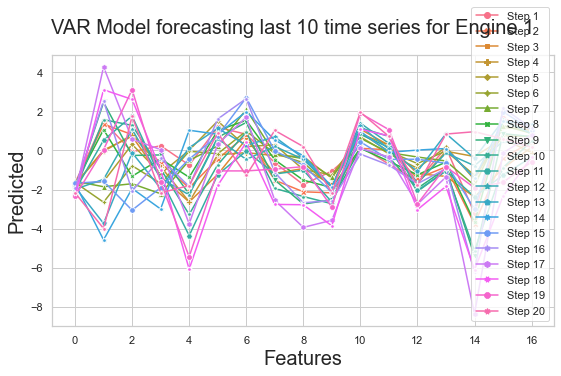

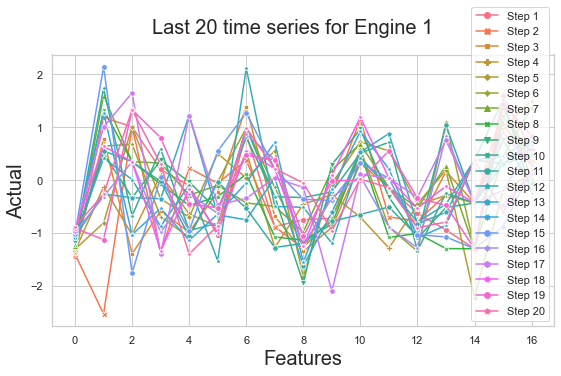

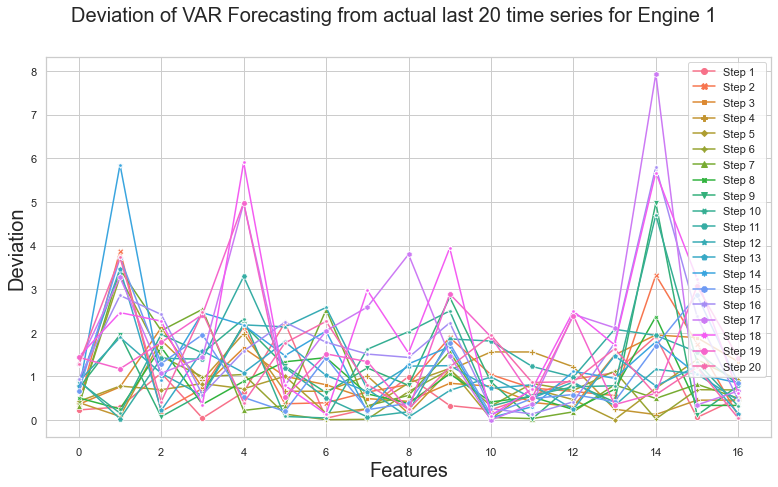

In [666]:
predictions = []
for i in range(len(y_new)):
    test_model = VAR(y_new[i][0:len(y_new[i])-20])
    test_model_fit = test_model.fit()
    test_pred = test_model_fit.forecast(test_model_fit.y, steps=20)
    predictions.append(test_pred)

predictions=np.array(predictions)

print(predictions.shape)

actual = []
for i in range(len(y_new)):
    actual.append(y_new[i].iloc[len(y_new[i])-20:])

actual = np.array(actual)

print(actual.shape)

# predictions = predictions.reshape((100,17,10))
# actual = actual.reshape((100,17,10))

diff = []
for i in range(100):
    a = []
    for j in range(20):
        b = []
        for k in range(17):
            b.append(abs(predictions[i][j][k]-actual[i][j][k]))
        a.append(b)
    diff.append(a)
diff = np.array(diff)
diff.shape

df1_actual=pd.DataFrame(actual[0])
df1_pred=pd.DataFrame(predictions[0])
df1_diff=pd.DataFrame(diff[0])
df1_actual,df1_pred,df1_diff = df1_actual.T,df1_pred.T,df1_diff.T

columns=[]
for i in range(20):
    columns.append('Step '+str(i+1))

df1_actual.columns = columns
df1_pred.columns = columns
df1_diff.columns = columns





display(df1_actual,df1_pred,df1_diff)



df_diff.describe()

sns.set_theme(style="whitegrid")
a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_pred,markers=True, dashes=False)
fig.suptitle('VAR Model forecasting last 10 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Predicted", fontsize=20)
plt.legend(loc='lower right')

sns.set_theme(style="whitegrid")
a4_dims = (9,5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_actual,markers=True, dashes=False)
fig.suptitle('Last 20 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Actual", fontsize=20)
plt.legend(loc='lower right')

sns.set_theme(style="whitegrid")
a4_dims = (13,7)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data = df1_diff,markers=True, dashes=False)
fig.suptitle('Deviation of VAR Forecasting from actual last 20 time series for Engine 1 ', fontsize=20)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Deviation", fontsize=20)
plt.legend(loc='upper right')

